In [1]:
pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in c:\users\mzig2\anaconda3\lib\site-packages (0.23.2)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ipynb

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install import_ipynb

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

## Data Management

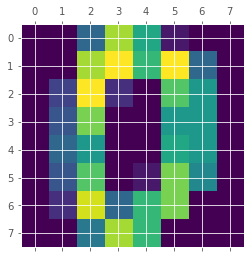

In [5]:
from sklearn.datasets import load_digits
 
digits = load_digits()
import matplotlib.pyplot as plt 
plt.matshow(digits.images[0]) 
plt.show()

In [6]:
#flattening to 1D arrays
#partitioning to training set, testing set, validation set
from sklearn.model_selection import train_test_split
X_train, X_other, y_train, y_other = train_test_split(digits.data, digits.images, test_size=0.2, shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_other, y_other, test_size=0.5, shuffle=False)
print("Numbers to train: " + str(len(X_train)))
print("Numbers to test: " + str(len(X_test)))
print("Numbers to validate: " + str(len(X_val)))

Numbers to train: 1437
Numbers to test: 180
Numbers to validate: 180


### Test set starts after training set in partition
### Validation set starts after test set

6


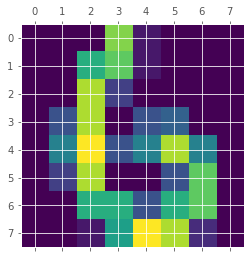

In [7]:
i=36
plt.matshow(X_test[i].reshape(8,8))
print(digits.target[len(X_train)+i])

## Poisson Encoding

### 2.2.d)

For this modified SNN, we decided to employ a Poisson Encoding scheme in order to generate a spike train representation for each of our images. Citing this paper https://arxiv.org/ftp/arxiv/papers/1604/1604.06751.pdf, our algorithm for doing so was as follows:

- normalize all r rate (pixel intensity) values to be between 0 and 1
- generate M uniform random numbers between 0 and 1 where M is equal to the number of bins of time we're examining spiking   activity (since dT = 1, M will be equal to the size of the array)
- for all i in M random numbers in rand, if r[i] > rand[i], generate 1 spike

After executing this process, 3 arrays will be returned of size M: one containing the normalized pixel intensities of each bin, one containing their binary spike values, and one consisting of the maximum amount of intensity at each index where a spike occurs for plotting purposes.

In [8]:
def poissonEncoding(rates):
    """
    Transforms a 2D array of inputs representing an image into spike train representation utilizing Poisson method of
    encoding
    
    Params:
        rates: 2D array of inputs (in this case, pixel intensitiies corresponding to our image)
    Returns:
        n_rates: Normalized set of input pixel values (represents probabilities of a spike occurring at each dT)
        bin_spikes: 2D array of binary values representing timesteps in which spikes occur
        p_spikes: 2D array representing pixel intensities of spike train representation for plotting/computation purposes
        
    """
    dT = 1
    
    max = np.amax(rates)
    n_rates = (rates*dT)/max
    
    rand = np.random.uniform(0,1, len(rates))
    bin_spikes = np.zeros(len(rates))
    pix_spikes = np.zeros(len(rates))
    
    for i in range(len(rates)):
        if n_rates[i] > rand[i]:
            bin_spikes[i] = 1
            pix_spikes[i] = max
                    
    return n_rates, bin_spikes, pix_spikes
    

0


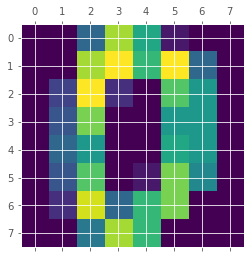

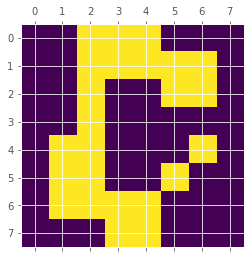

1797

In [9]:
plt.matshow(np.reshape(X_train[0], (8,8))) 
print(digits.target[0])
n, b, p = poissonEncoding(X_train[0])
plt.matshow(p.reshape(8,8))
plt.show()

len(digits.images)

 ## Network Functions

In [10]:
def train(X, Y, l_rt, init, epochs):
    
    weights = init
    
    for i in range(epochs):
        
        print("epoch: ", i)
        
        for x in range(len(X)):
            
            true_index = digits.target[x]
            print("index: ", x, " true index: ", true_index)
            in_neurons = X[x]
            out_neurons = Y[x]
            
            X_n_rts, X_bins, X_pixs = poissonEncoding(in_neurons)
                        
            weight_adjs = np.zeros((len(in_neurons),10))
            
            y_out  = np.zeros((10,len(in_neurons)))
            y_out[true_index] = out_neurons.flatten()
                        
            for pix in range(len(in_neurons)):
                for digit in range(10):
                   weight_adjs[pix][digit] = l_rt*X_bins[pix]*y_out[digit][pix]
                
            weights = weights + weight_adjs
            
        print("--------------------------")
        print("weights after epoch ", i,": ", weights, "\n")
        
    return weights.T


def validate(train, val, weights, ind_train, ind_val):
    
    train_correct = 0
    val_correct = 0
    
    for i in range(len(train)):
        prediction = _predict(train[i], weights)
        if prediction == digits.target[ind_train+i]:
            train_correct+=1
    train_accuracy = train_correct/len(train)
    print("training accuracy: ", train_accuracy)
    
    for j in range(len(val)):
        prediction = _predict(val[j], weights)
        if prediction == digits.target[ind_val+j]:
            val_correct+=1
    val_accuracy = val_correct/len(val)
    print("validation accuracy: ", val_accuracy)
    
    print("total accuracy: ", (train_correct+val_correct)/(len(train)+len(val)))
    
        

def predict(test, weights, targ):
    
    print("image value: ", targ)
    
    n, spikes, p = poissonEncoding(test)
    outs = np.zeros(len(weights))
    for i in range(len(weights)):
        outs[i] = np.dot(spikes, weights[i])
    
    prediction = np.argmax(outs)
    
    print("predicted value: ", prediction)
    
    if (prediction == targ):
        return True
    else:
        return False
    
def _predict(test, weights):
    
    n, spikes, p = poissonEncoding(test)
    outs = np.zeros(len(weights))
    
    for i in range(len(weights)):
        outs[i] = np.dot(spikes, weights[i])
    
    return np.argmax(outs)
    
def sim(test, weights, ind_targ):
    
    correct = 0
    
    for i in range(len(test)):
        
        x = predict(test[i], weights, digits.target[ind_targ+i])
        
        print("prediction correct: ", x)
        print("--------------------------")
        
        if x:
            correct += 1
            
    return correct/len(test) 


## Training

In [11]:
init_weights = np.zeros((len(X_train[0]),10))

#w_i,j = w_out,pix
weights = train(X_train, y_train, 0.0008, init_weights, 3)

epoch:  0
index:  0  true index:  0
index:  1  true index:  1
index:  2  true index:  2
index:  3  true index:  3
index:  4  true index:  4
index:  5  true index:  5
index:  6  true index:  6
index:  7  true index:  7
index:  8  true index:  8
index:  9  true index:  9
index:  10  true index:  0
index:  11  true index:  1
index:  12  true index:  2
index:  13  true index:  3
index:  14  true index:  4
index:  15  true index:  5
index:  16  true index:  6
index:  17  true index:  7
index:  18  true index:  8
index:  19  true index:  9
index:  20  true index:  0
index:  21  true index:  1
index:  22  true index:  2
index:  23  true index:  3
index:  24  true index:  4
index:  25  true index:  5
index:  26  true index:  6
index:  27  true index:  7
index:  28  true index:  8
index:  29  true index:  9
index:  30  true index:  0
index:  31  true index:  9
index:  32  true index:  5
index:  33  true index:  5
index:  34  true index:  6
index:  35  true index:  5
index:  36  true index:  0
i

index:  381  true index:  9
index:  382  true index:  0
index:  383  true index:  8
index:  384  true index:  9
index:  385  true index:  3
index:  386  true index:  0
index:  387  true index:  1
index:  388  true index:  2
index:  389  true index:  3
index:  390  true index:  4
index:  391  true index:  5
index:  392  true index:  6
index:  393  true index:  7
index:  394  true index:  8
index:  395  true index:  9
index:  396  true index:  0
index:  397  true index:  1
index:  398  true index:  2
index:  399  true index:  3
index:  400  true index:  4
index:  401  true index:  5
index:  402  true index:  6
index:  403  true index:  7
index:  404  true index:  8
index:  405  true index:  9
index:  406  true index:  0
index:  407  true index:  1
index:  408  true index:  2
index:  409  true index:  3
index:  410  true index:  4
index:  411  true index:  5
index:  412  true index:  6
index:  413  true index:  7
index:  414  true index:  8
index:  415  true index:  9
index:  416  true in

index:  770  true index:  4
index:  771  true index:  9
index:  772  true index:  0
index:  773  true index:  8
index:  774  true index:  9
index:  775  true index:  8
index:  776  true index:  0
index:  777  true index:  1
index:  778  true index:  2
index:  779  true index:  3
index:  780  true index:  4
index:  781  true index:  5
index:  782  true index:  6
index:  783  true index:  7
index:  784  true index:  8
index:  785  true index:  9
index:  786  true index:  0
index:  787  true index:  1
index:  788  true index:  2
index:  789  true index:  3
index:  790  true index:  4
index:  791  true index:  5
index:  792  true index:  6
index:  793  true index:  7
index:  794  true index:  8
index:  795  true index:  9
index:  796  true index:  0
index:  797  true index:  1
index:  798  true index:  2
index:  799  true index:  3
index:  800  true index:  4
index:  801  true index:  5
index:  802  true index:  6
index:  803  true index:  7
index:  804  true index:  8
index:  805  true in

index:  1171  true index:  4
index:  1172  true index:  5
index:  1173  true index:  6
index:  1174  true index:  7
index:  1175  true index:  8
index:  1176  true index:  9
index:  1177  true index:  0
index:  1178  true index:  1
index:  1179  true index:  2
index:  1180  true index:  3
index:  1181  true index:  4
index:  1182  true index:  5
index:  1183  true index:  6
index:  1184  true index:  7
index:  1185  true index:  8
index:  1186  true index:  9
index:  1187  true index:  0
index:  1188  true index:  9
index:  1189  true index:  5
index:  1190  true index:  5
index:  1191  true index:  6
index:  1192  true index:  5
index:  1193  true index:  0
index:  1194  true index:  9
index:  1195  true index:  8
index:  1196  true index:  9
index:  1197  true index:  8
index:  1198  true index:  4
index:  1199  true index:  1
index:  1200  true index:  7
index:  1201  true index:  7
index:  1202  true index:  3
index:  1203  true index:  5
index:  1204  true index:  1
index:  1205  

index:  124  true index:  4
index:  125  true index:  9
index:  126  true index:  0
index:  127  true index:  8
index:  128  true index:  9
index:  129  true index:  8
index:  130  true index:  0
index:  131  true index:  1
index:  132  true index:  2
index:  133  true index:  3
index:  134  true index:  4
index:  135  true index:  5
index:  136  true index:  6
index:  137  true index:  7
index:  138  true index:  8
index:  139  true index:  9
index:  140  true index:  0
index:  141  true index:  1
index:  142  true index:  2
index:  143  true index:  3
index:  144  true index:  4
index:  145  true index:  5
index:  146  true index:  6
index:  147  true index:  7
index:  148  true index:  8
index:  149  true index:  9
index:  150  true index:  0
index:  151  true index:  1
index:  152  true index:  2
index:  153  true index:  3
index:  154  true index:  4
index:  155  true index:  5
index:  156  true index:  6
index:  157  true index:  7
index:  158  true index:  8
index:  159  true in

index:  512  true index:  0
index:  513  true index:  8
index:  514  true index:  9
index:  515  true index:  8
index:  516  true index:  0
index:  517  true index:  1
index:  518  true index:  2
index:  519  true index:  3
index:  520  true index:  4
index:  521  true index:  5
index:  522  true index:  6
index:  523  true index:  7
index:  524  true index:  8
index:  525  true index:  9
index:  526  true index:  0
index:  527  true index:  1
index:  528  true index:  2
index:  529  true index:  3
index:  530  true index:  4
index:  531  true index:  5
index:  532  true index:  6
index:  533  true index:  7
index:  534  true index:  8
index:  535  true index:  9
index:  536  true index:  0
index:  537  true index:  1
index:  538  true index:  2
index:  539  true index:  3
index:  540  true index:  4
index:  541  true index:  5
index:  542  true index:  6
index:  543  true index:  7
index:  544  true index:  8
index:  545  true index:  9
index:  546  true index:  0
index:  547  true in

index:  842  true index:  6
index:  843  true index:  6
index:  844  true index:  4
index:  845  true index:  9
index:  846  true index:  1
index:  847  true index:  5
index:  848  true index:  0
index:  849  true index:  9
index:  850  true index:  5
index:  851  true index:  2
index:  852  true index:  8
index:  853  true index:  2
index:  854  true index:  0
index:  855  true index:  0
index:  856  true index:  1
index:  857  true index:  7
index:  858  true index:  6
index:  859  true index:  3
index:  860  true index:  2
index:  861  true index:  1
index:  862  true index:  7
index:  863  true index:  4
index:  864  true index:  6
index:  865  true index:  3
index:  866  true index:  1
index:  867  true index:  3
index:  868  true index:  9
index:  869  true index:  1
index:  870  true index:  7
index:  871  true index:  6
index:  872  true index:  8
index:  873  true index:  4
index:  874  true index:  3
index:  875  true index:  1
index:  876  true index:  4
index:  877  true in

index:  1280  true index:  8
index:  1281  true index:  4
index:  1282  true index:  9
index:  1283  true index:  0
index:  1284  true index:  8
index:  1285  true index:  9
index:  1286  true index:  8
index:  1287  true index:  0
index:  1288  true index:  1
index:  1289  true index:  2
index:  1290  true index:  3
index:  1291  true index:  4
index:  1292  true index:  5
index:  1293  true index:  6
index:  1294  true index:  7
index:  1295  true index:  8
index:  1296  true index:  9
index:  1297  true index:  0
index:  1298  true index:  1
index:  1299  true index:  2
index:  1300  true index:  3
index:  1301  true index:  4
index:  1302  true index:  5
index:  1303  true index:  6
index:  1304  true index:  7
index:  1305  true index:  8
index:  1306  true index:  9
index:  1307  true index:  0
index:  1308  true index:  1
index:  1309  true index:  2
index:  1310  true index:  3
index:  1311  true index:  4
index:  1312  true index:  5
index:  1313  true index:  6
index:  1314  

index:  24  true index:  4
index:  25  true index:  5
index:  26  true index:  6
index:  27  true index:  7
index:  28  true index:  8
index:  29  true index:  9
index:  30  true index:  0
index:  31  true index:  9
index:  32  true index:  5
index:  33  true index:  5
index:  34  true index:  6
index:  35  true index:  5
index:  36  true index:  0
index:  37  true index:  9
index:  38  true index:  8
index:  39  true index:  9
index:  40  true index:  8
index:  41  true index:  4
index:  42  true index:  1
index:  43  true index:  7
index:  44  true index:  7
index:  45  true index:  3
index:  46  true index:  5
index:  47  true index:  1
index:  48  true index:  0
index:  49  true index:  0
index:  50  true index:  2
index:  51  true index:  2
index:  52  true index:  7
index:  53  true index:  8
index:  54  true index:  2
index:  55  true index:  0
index:  56  true index:  1
index:  57  true index:  2
index:  58  true index:  6
index:  59  true index:  3
index:  60  true index:  3
i

index:  416  true index:  0
index:  417  true index:  9
index:  418  true index:  5
index:  419  true index:  5
index:  420  true index:  6
index:  421  true index:  5
index:  422  true index:  0
index:  423  true index:  9
index:  424  true index:  8
index:  425  true index:  9
index:  426  true index:  8
index:  427  true index:  4
index:  428  true index:  1
index:  429  true index:  7
index:  430  true index:  7
index:  431  true index:  3
index:  432  true index:  5
index:  433  true index:  1
index:  434  true index:  0
index:  435  true index:  0
index:  436  true index:  2
index:  437  true index:  2
index:  438  true index:  7
index:  439  true index:  8
index:  440  true index:  2
index:  441  true index:  0
index:  442  true index:  1
index:  443  true index:  2
index:  444  true index:  6
index:  445  true index:  3
index:  446  true index:  3
index:  447  true index:  7
index:  448  true index:  3
index:  449  true index:  3
index:  450  true index:  4
index:  451  true in

index:  828  true index:  7
index:  829  true index:  8
index:  830  true index:  2
index:  831  true index:  0
index:  832  true index:  1
index:  833  true index:  2
index:  834  true index:  6
index:  835  true index:  3
index:  836  true index:  3
index:  837  true index:  7
index:  838  true index:  3
index:  839  true index:  3
index:  840  true index:  4
index:  841  true index:  6
index:  842  true index:  6
index:  843  true index:  6
index:  844  true index:  4
index:  845  true index:  9
index:  846  true index:  1
index:  847  true index:  5
index:  848  true index:  0
index:  849  true index:  9
index:  850  true index:  5
index:  851  true index:  2
index:  852  true index:  8
index:  853  true index:  2
index:  854  true index:  0
index:  855  true index:  0
index:  856  true index:  1
index:  857  true index:  7
index:  858  true index:  6
index:  859  true index:  3
index:  860  true index:  2
index:  861  true index:  1
index:  862  true index:  7
index:  863  true in

index:  1216  true index:  3
index:  1217  true index:  3
index:  1218  true index:  7
index:  1219  true index:  3
index:  1220  true index:  3
index:  1221  true index:  4
index:  1222  true index:  6
index:  1223  true index:  6
index:  1224  true index:  6
index:  1225  true index:  4
index:  1226  true index:  9
index:  1227  true index:  1
index:  1228  true index:  5
index:  1229  true index:  0
index:  1230  true index:  9
index:  1231  true index:  5
index:  1232  true index:  2
index:  1233  true index:  8
index:  1234  true index:  2
index:  1235  true index:  0
index:  1236  true index:  0
index:  1237  true index:  1
index:  1238  true index:  7
index:  1239  true index:  6
index:  1240  true index:  3
index:  1241  true index:  2
index:  1242  true index:  1
index:  1243  true index:  7
index:  1244  true index:  4
index:  1245  true index:  6
index:  1246  true index:  3
index:  1247  true index:  1
index:  1248  true index:  3
index:  1249  true index:  9
index:  1250  

## Validation Testing

In [12]:
validate(X_train, X_val, weights, 0, len(X_train)+len(X_test))

training accuracy:  0.7411273486430062
validation accuracy:  0.6555555555555556
total accuracy:  0.7316017316017316


## Final Testing

In [13]:
accuracy = sim(X_test, weights, len(X_train))
print("accuracy: ", accuracy)

image value:  2
predicted value:  2
prediction correct:  True
--------------------------
image value:  3
predicted value:  1
prediction correct:  False
--------------------------
image value:  4
predicted value:  4
prediction correct:  True
--------------------------
image value:  5
predicted value:  5
prediction correct:  True
--------------------------
image value:  6
predicted value:  6
prediction correct:  True
--------------------------
image value:  7
predicted value:  7
prediction correct:  True
--------------------------
image value:  8
predicted value:  1
prediction correct:  False
--------------------------
image value:  9
predicted value:  3
prediction correct:  False
--------------------------
image value:  0
predicted value:  0
prediction correct:  True
--------------------------
image value:  9
predicted value:  1
prediction correct:  False
--------------------------
image value:  5
predicted value:  5
prediction correct:  True
--------------------------
image value:  5
p